## 1. Data from https://www.cell.com/cell-reports-medicine/pdf/S2666-3791(20)30068-9.pdf:

### Alignment

In [14]:
virus_index = "/home/laura/projects/virus-watch-data/virus_ref/kallisto_aa/noduplicates_human_dna_cdna.idx"
virus_t2g = "/home/laura/projects/virus-watch-data/virus_ref/nodup_clu_t2g.txt"

bp = "PRJNA631969"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}/raw"
out_folder = f"{fastq_folder}/.."

kallisto = "/home/laura/temp/kallisto/build/src/kallisto"
bustools = "/home/laura/projects/bustools/build/src/bustools"

Get fastq files:

In [15]:
import os
import glob

In [16]:
fastqs = []
for filename in glob.glob(f"{fastq_folder}/*.fastq.gz"):
    fastqs.append(filename.split("/")[-1])
    
fastqs.sort()
fastqs

['Cov1.fastq.gz',
 'Cov2.fastq.gz',
 'Cov3.fastq.gz',
 'Mock1.fastq.gz',
 'Mock2.fastq.gz',
 'Mock3.fastq.gz']

Loop over files and align one at a time:

In [17]:
%%time

for fastq in fastqs:
    sample = fastq.split(".fastq.gz")[0]
    
    !mkdir -p $out_folder/$sample
    
    !$kallisto bus \
            -i $virus_index \
            -o $out_folder/$sample/ \
            --aa \
            -t 30 \
            -x bulk \
            $fastq_folder/$fastq \
            &> $out_folder/$sample/kb_out.txt 
        
    !$bustools sort -o $out_folder/$sample/output_sorted.bus $out_folder/$sample/output.bus

    !$bustools count \
        --genecounts \
        --cm \
        -o $out_folder/$sample/bustools_count/ \
        -g $virus_t2g \
        -e $out_folder/$sample/matrix.ec \
        -t $out_folder/$sample/transcripts.txt \
        $out_folder/$sample/output_sorted.bus

 all fits in buffer
Read in 16651 BUS records
reading time 0s
sorting time 0s
writing time 0s
 all fits in buffer
Read in 20606 BUS records
reading time 0s
sorting time 0.01s
writing time 0s
 all fits in buffer
Read in 15362 BUS records
reading time 0s
sorting time 0.01s
writing time 0s
 all fits in buffer
Read in 1801 BUS records
reading time 0s
sorting time 0s
writing time 0s
 all fits in buffer
Read in 2244 BUS records
reading time 0s
sorting time 0s
writing time 0s
 all fits in buffer
Read in 1802 BUS records
reading time 0s
sorting time 0s
writing time 0s
CPU times: user 38.9 s, sys: 9.22 s, total: 48.2 s
Wall time: 40min 38s


### Plot virus counts

In [18]:
import kb_python.utils as kb_utils
import anndata
import numpy as np
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.colors
%config InlineBackend.figure_format='retina'

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [19]:
u_tax_csv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

Get fastq names:

In [20]:
fastqs = []
for filename in glob.glob(f"{fastq_folder}/*.fastq.gz"):
    fastqs.append(filename.split("/")[-1])
    
fastqs.sort()
fastqs

['Cov1.fastq.gz',
 'Cov2.fastq.gz',
 'Cov3.fastq.gz',
 'Mock1.fastq.gz',
 'Mock2.fastq.gz',
 'Mock3.fastq.gz']

Create adata objects from raw data:

In [21]:
adatas = []
for fastq in fastqs:
    # Load data
    sample = fastq.split(".fastq.gz")[0]
    results_dir = f"{out_folder}/{sample}"

    # Filepath to counts
    X = f"{results_dir}/bustools_count/output.mtx"
    # Filepath to barcode metadata
    var_path = f"{results_dir}/bustools_count/output.genes.txt"
    # Filepath to gene metadata
    obs_path = f"{results_dir}/bustools_count/output.barcodes.txt" 

    # Create AnnData object
    adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

    # Add sample name
    adata.obs["sample"] = sample

    # Append to adata list
    adatas.append(adata)

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype exp

In [22]:
adata = anndata.concat(adatas, merge="same")
# Set sample as index
adata.obs = adata.obs.set_index("sample")
adata.obs

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


""
sample
Cov1
Cov2
Cov3
Mock1
Mock2
Mock3


In [23]:
adata.write(f"/home/laura/projects/virus-watch-data/{bp}/{bp}_combined_meta_final.h5ad")

In [24]:
# adata = anndata.read("/home/laura/projects/virus-watch-data/PRJNA631969/PRJNA631969_combined_meta_final.h5ad")
# adata

In [25]:
adata.obs

""
sample
Cov1
Cov2
Cov3
Mock1
Mock2
Mock3


In [26]:
tax_df = pd.read_csv(u_tax_csv)
tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
404,u889,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
405,u9015,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
406,u944,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
407,u9771,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


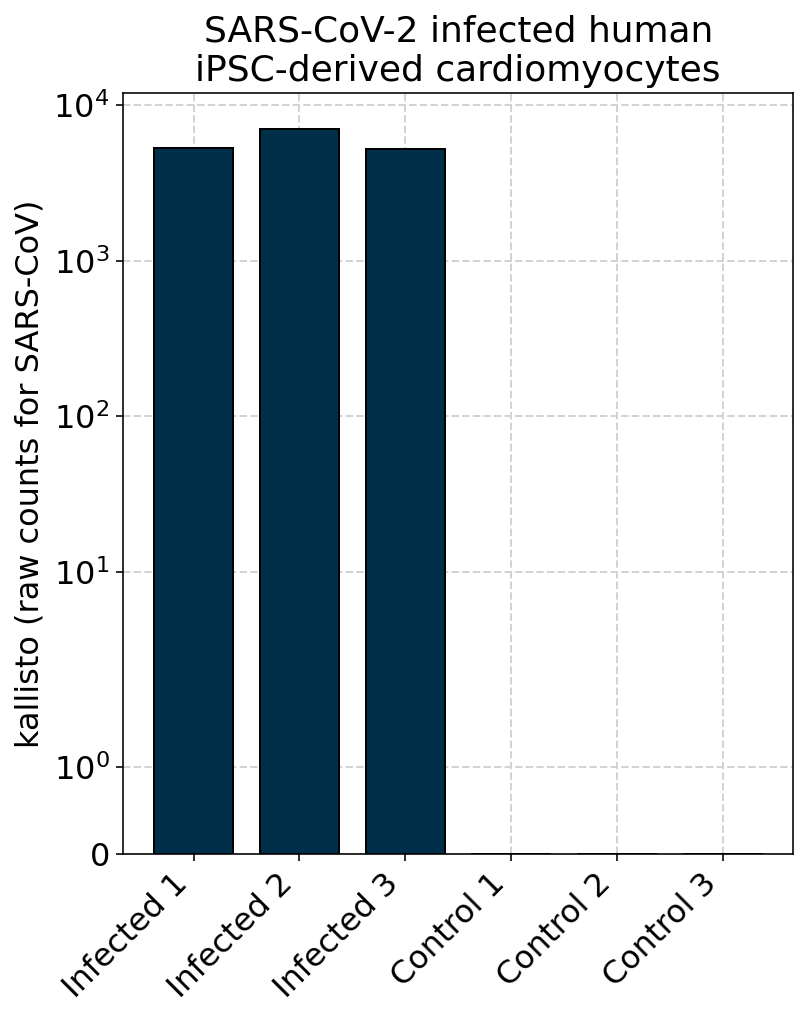

In [33]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 16
width = 0.75

x_labels = ['Infected 1', 'Infected 2', 'Infected 3', 'Control 1', 'Control 2', 'Control 3']

target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].unique()

counts = []
samples = adata.obs.index.values
labels = samples
for sample in samples:
    counts.append(adata.X[adata.obs.index == sample, adata.var.index.isin(target_ids)].sum())    
        
x = np.arange(len(labels))

ax.bar(x, counts, width=width, color="#003049", edgecolor="black")

ax.set_yscale("symlog")
ax.set_ylabel("kallisto (raw counts for SARS-CoV)", fontsize=fontsize)
# ax.set_xlabel("Sample", fontsize=fontsize)

ax.set_xticks(x, x_labels, rotation=45, ha="right")
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"SARS-CoV-2 infected human\niPSC-derived cardiomyocytes", fontsize=fontsize+2)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)
    
# plt.tight_layout()

plt.savefig("figures/smartseq_benchmark_PRJNA631969.png", dpi=300, bbox_inches="tight")

fig.show()

In [28]:
counts

[5265.0, 7037.0, 5187.0, 0.0, 0.0, 0.0]

Counts obtained with previous workflow: [5265.0, 7037.0, 5187.0, 0.0, 0.0, 0.0]

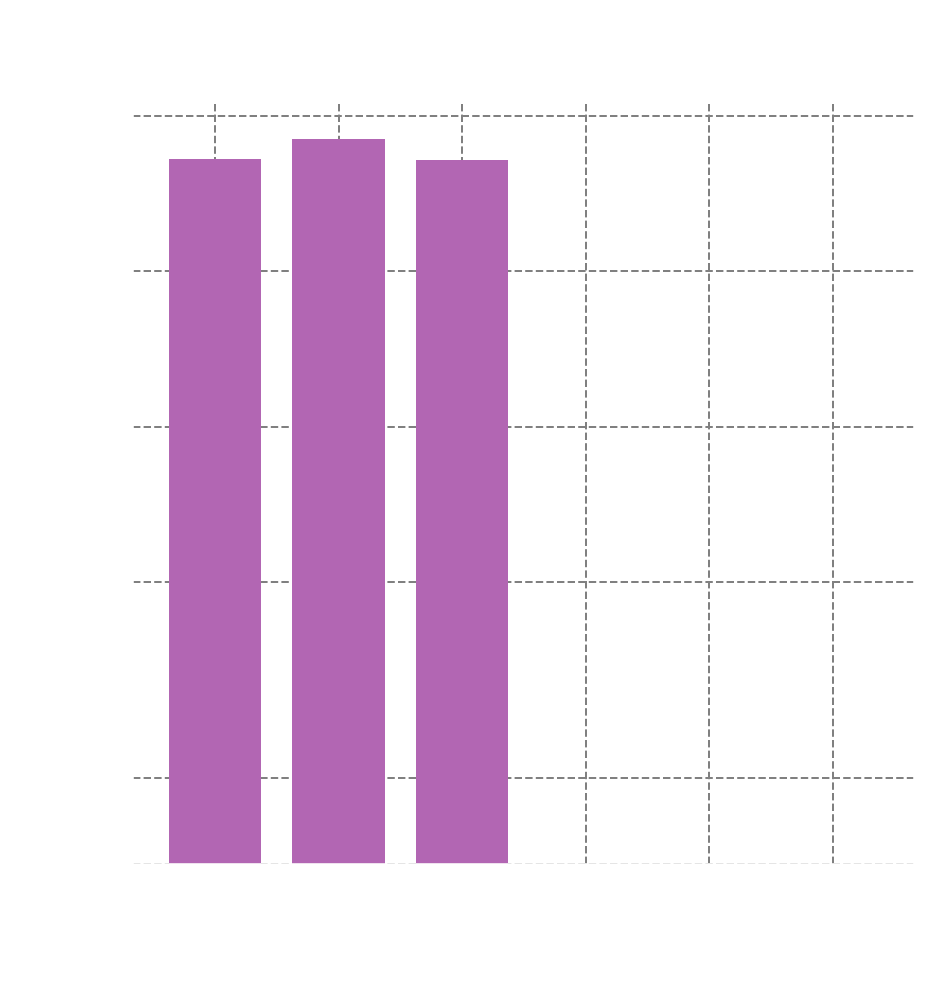

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 18
width = 0.75
label_color = "white"

counts = []
samples = adata.obs.index.values
labels = samples
for sample in samples:
    counts.append(adata.X[adata.obs.index == sample, adata.var.index.isin(target_ids)].sum())
        
x = np.arange(len(labels))

ax.bar(x, counts, width=width, color="#b266b3")

ax.set_yscale("symlog")
ax.set_ylabel("kallisto (total Coronavirus counts)", fontsize=fontsize, color=label_color)
# ax.set_xlabel("Sample", fontsize=fontsize)

ax.set_xticks(x, x_labels, rotation=25, ha="right")
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"SARS-CoV-2 in human\niPSC-derived cardiomyocytes", fontsize=fontsize+2, color=label_color)

ax.grid(True, which="both", color="grey", ls="--", lw=1)
ax.set_axisbelow(True)

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='both', colors='white')

plt.savefig("figures/smartseq_benchmark_PRJNA631969_white.png", dpi=300, bbox_inches="tight", transparent=True)

fig.show()